#10. 나를 찾아줘 - Class Activation Map 만들기

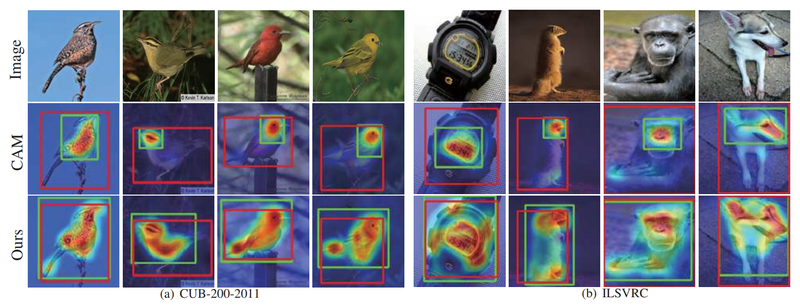

이번 프로젝트는 **CAM(Class Activation Map)을 얻기 위한 방법 중 기본 CAM과 Grad-CAM을 구현해보고 이를 시각화**해 보겠습니다. 

그리고 **CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교**해 보겠습니다.

**CAM(Class Activation Map) 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)**와 

**소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약**이 있습니다. 

반면에 **Grad-CAM은 이러한 제약이 없죠**.

따라서 **CAM과 Grad-CAM, 이 두 가지를 모두 구현해 보겠습니다**.

우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 

이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. 

Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

**CAM은 클래스에 대한 활성화 정도를 나타낸 지도** 입니다.

따라서 기본적으로 우리의 모델은 **분류(classfication) 를 수행하는 모델**이어야 합니다. 

하지만 우리의 **최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인**하고 

이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 

여기서는 stanford_dogs 데이터셋을 사용하겠습니다. 

이는 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 

라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있습니다. 

그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

----

목차

- 데이터셋과 라이브러리 임포트

- 데이터 전처리

- 모델 설계 및 학습

- 모델 가중치 저장 및 로드

- CAM

- Grad CAM

- Grad CAM IOU 구하기

- 번외

- 마무리

---

##데이터셋과 라이브러리 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteFAJLAS/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteFAJLAS/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


---

##데이터 전처리

In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(12000, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(8580, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

-----

###라벨 확인

In [ ]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

---

###데이터 시각화

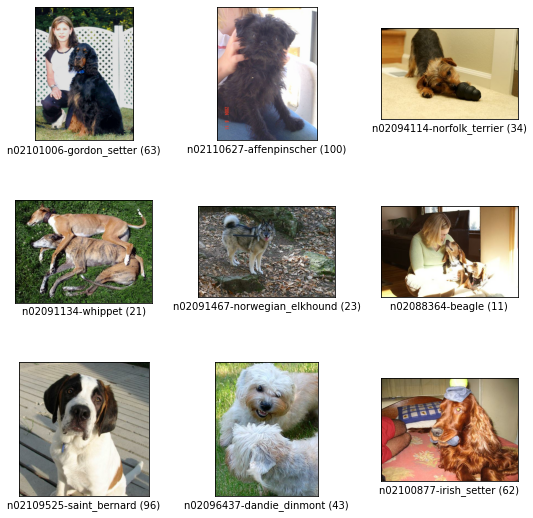

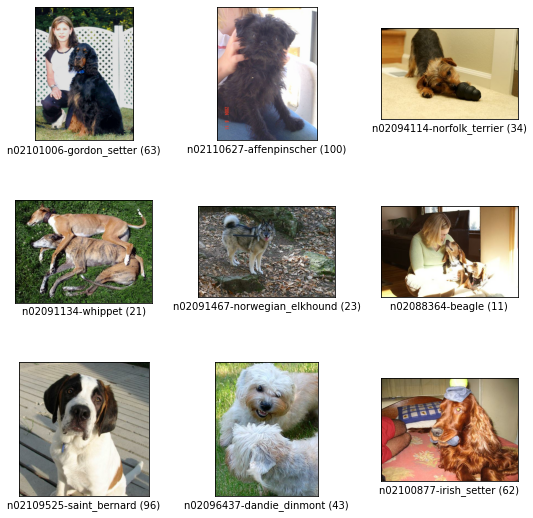

In [ ]:
tfds.show_examples(ds_train, ds_info)

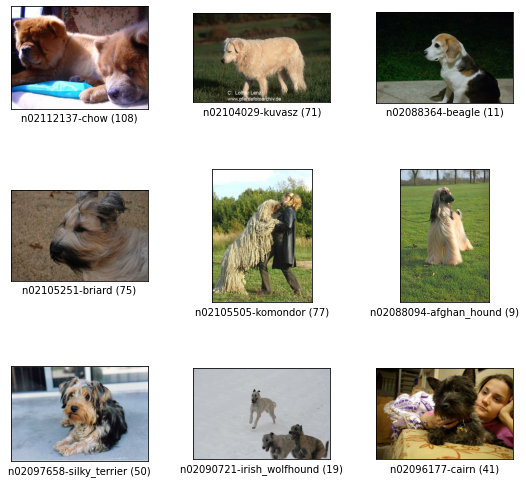

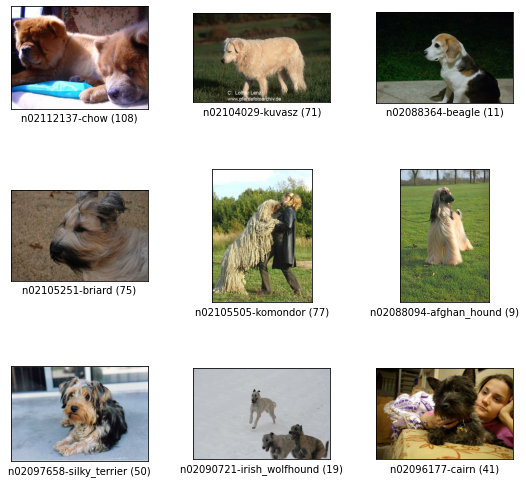

In [ ]:
tfds.show_examples(ds_test, ds_info)

---

###정규화 및 데이터셋 분리

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


---

##모델 설계 및 학습

###CAM 모델 설계

백본으로 ResNet50을 사용하도록 하겠습니다.

즉, 미리 이미지넷 데이터에 훈련된 ResNet50을 불러오고

그 뒤에 GAP와 softmax를 적용시켜 CAM 모델을 생성하겠습니다.

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

---

###모델 학습

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs = 15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
750/750 [==============================] - 185s 218ms/step - loss: 2.1779 - accuracy: 0.4513 - val_loss: 3.1762 - val_accuracy: 0.2442
Epoch 2/15
750/750 [==============================] - 162s 216ms/step - loss: 0.7070 - accuracy: 0.8072 - val_loss: 1.1296 - val_accuracy: 0.6660
Epoch 3/15
750/750 [==============================] - 162s 216ms/step - loss: 0.1995 - accuracy: 0.9604 - val_loss: 0.9539 - val_accuracy: 0.7160
Epoch 4/15
750/750 [==============================] - 162s 216ms/step - loss: 0.0752 - accuracy: 0.9913 - val_loss: 0.9352 - val_accuracy: 0.7291
Epoch 5/15
750/750 [==============================] - 162s 216ms/step - loss: 0.0259 - accuracy: 0.9991 - val_loss: 0.9237 - val_accuracy: 0.7322
Epoch 6/15
750/750 [==============================] - 162s 216ms/step - loss: 0.0228 - accuracy: 0.9992 - val_loss: 0.9268 - val_accuracy: 0.7386
Epoch 7/15
750/750 [==============================] - 162s 216ms/step - loss: 0.0106 - accuracy: 0.9997 - val_loss: 0.9250 -

###학습 결과 시각화

In [ ]:
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # CAM Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('CAM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # CAM Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('CAM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

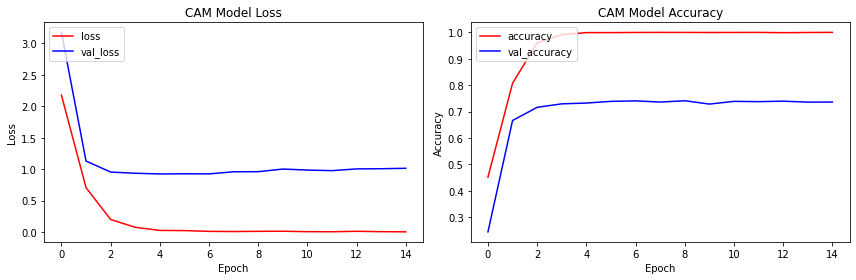

In [ ]:
draw_history(history)

---

##모델 가중치 저장 및 로드

학습된 모델 가중치를 저장 시키고 불러오겠습니다.

이런식으로 가중치를 저장 시키면 나중에 다시 실행시 모델을 재학습 시키지 않아도 됩니다.

In [ ]:
import os

cam_model_path = '/content/drive/MyDrive/책/cam_model1.h5'
cam_model.save(cam_model_path)

In [ ]:
cam_model_path = '/content/drive/MyDrive/책/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

---

##CAM

###CAM 생성할 이미지 가져오기

해당 이미지로 CAM을 얻어보겠습니다.

108


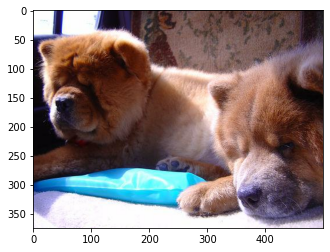

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

---

###CAM 생성

CAM을 생성하기 위해서는 **(1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치,** 

그리고 **(3) 원하는 클래스의 출력값이 필요**합니다. 

또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 

**네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화**해야 할 것입니다. 

이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

**generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의**하고, 

feedforward를 거친 후 CAM을 계산하도록 구현하였습니다.

마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [ ]:
cam_image = generate_cam(cam_model, item)

---

###CAM 이미지 출력, CAM과 원본 이미지 합침

이렇게 생성된 CAM을 출력해보고 원본 이미지와 합쳐보겠습니다.

In [ ]:
def show_image(cam_image):
  fig = plt.figure(figsize = (15, 10))
  plt.subplot(1, 2, 1)
  cam_image = generate_cam(cam_model, item)
  plt.imshow(cam_image)
  origin_image = item['image'].astype(np.uint8)
  cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

  def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

  blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
  plt.subplot(1, 2, 2)
  plt.imshow(blended_image)
  plt.show()

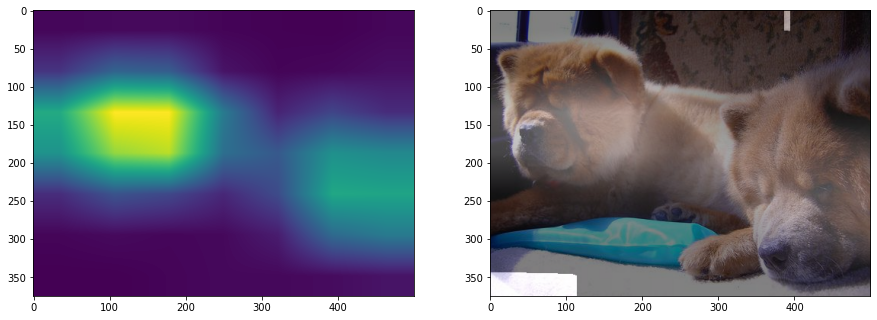

In [ ]:
show_image(cam_image)

---

##Grad-CAM

108


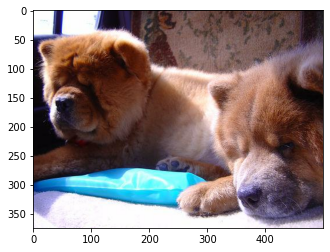

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

###Grad-CAM 생성

**grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고**, 

여기에 **GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다**. 

최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 

레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

이전 스텝에서 본 **CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로**, 

그래디언트 계산을 원하는 **관찰 대상 레이어 activation_layer를** 

**뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다**.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 

특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.



In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

---

###Grad_CAM 이미지 출력, CAM과 원본 이미지 합침

**Grad_CAM은 가중치 확인으로 모델이 어떤식으로 학습하는지 확인**할 수 있습니다.

즉, **레이어별로 확인**할 수가 있습니다.

전체 레이어를 뽑아서 Grad_CAM을 생성하고 원본 이미지와 합쳐 보겠습니다.

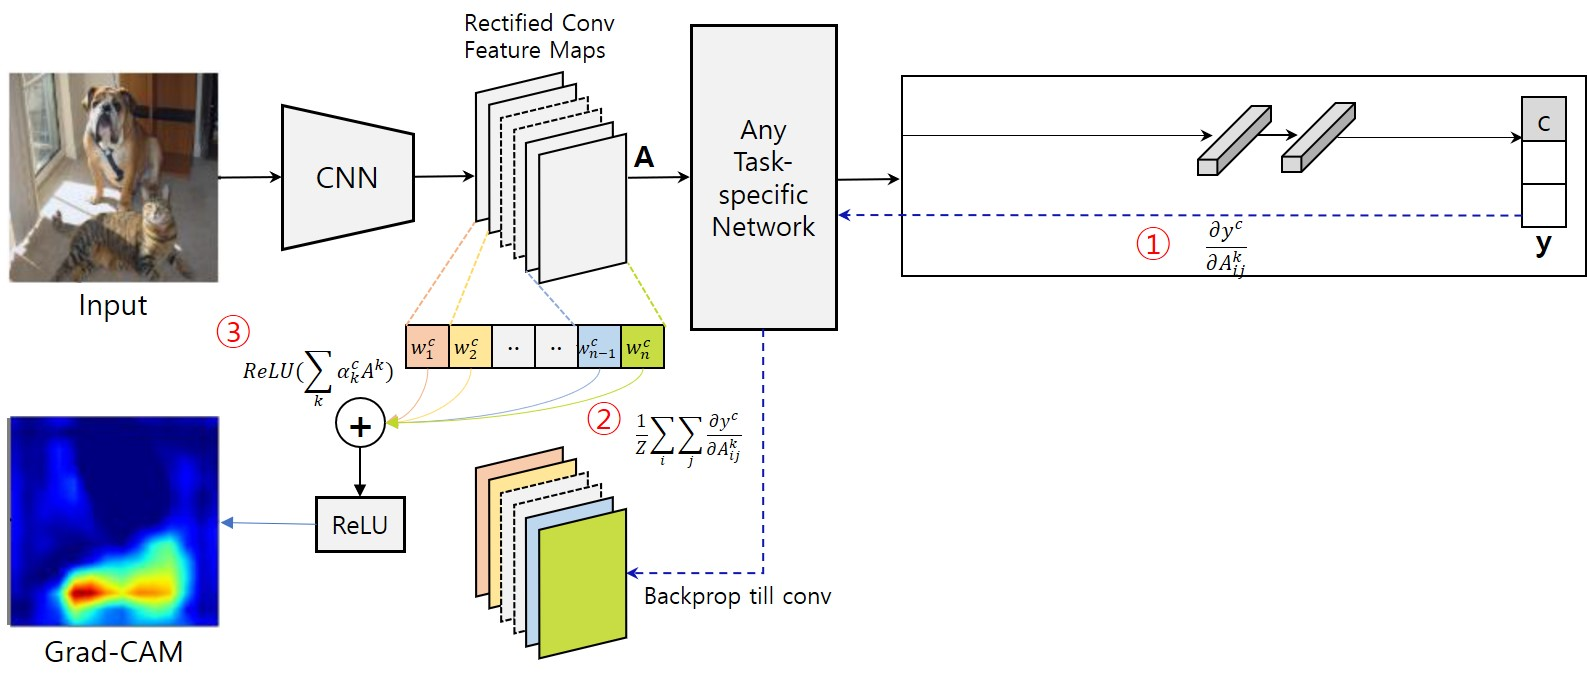

**visualize_cam_on_image1 함수에서는 렐루를 정의하기 위해서 0을 곱해주었습니다**.


In [ ]:
def visualize_cam_on_image1(item, cam_image, alpha=0.5):
    origin_image = item['image'].astype(np.uint8)
    #음수를 없애주기 위하여 relu처리
    cam_image_3channel = np.stack(np.maximum([cam_image*255]*3,0), axis=-1).astype(np.uint8)

    blended_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, 1.0-alpha, 0.0)
    return blended_image

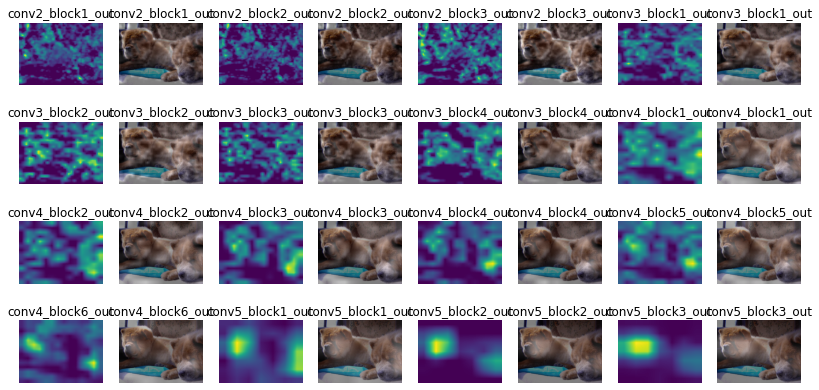

In [ ]:
#확인할 레이어수를 리스트로 저장
names = [
    'conv2_block1_out',
    'conv2_block2_out',
    'conv2_block3_out',
    'conv3_block1_out',
    'conv3_block2_out',
    'conv3_block3_out',
    'conv3_block4_out',
    'conv4_block1_out',
    'conv4_block2_out',
    'conv4_block3_out',
    'conv4_block4_out',
    'conv4_block5_out',
    'conv4_block6_out',
    'conv5_block1_out',
    'conv5_block2_out',
    'conv5_block3_out',
]

#결과값 저장 리스트
grad_cam_images = []
blended_images = []

len_ = len(names)  # 16
cols = 8
rows = len_//cols * 2

plt.figure(figsize=(14,7))
j = 1

#리스트에 저장된 레이에 수만큼 반복하며 Grad_CAM추출
for i in range(len(names)):
    grad_cam_image = generate_grad_cam(cam_model, names[i], item)
    blended_image = visualize_cam_on_image1(item, grad_cam_image)
    grad_cam_images.append(grad_cam_image)
    blended_images.append(blended_image)

    plt.subplot(rows,cols,j)
    plt.title(names[i])
    plt.imshow(grad_cam_image)
    j += 1

    plt.subplot(rows,cols,j)
    plt.title(names[i])
    plt.imshow(blended_image)
    j += 1

plt.show()

----

##CAM IOU 구하기

마지막으로 CAM에서 물체의 위치를 찾고 IOU를 계산해 성능이 어느정도인지 확인해보겠습니다.

67


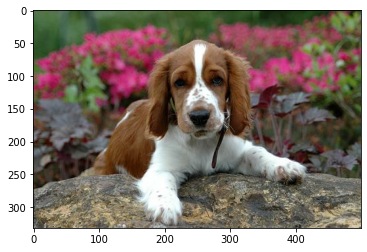

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

---

###CAM이미지 추출

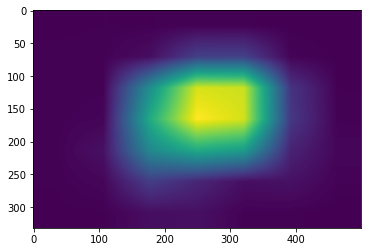

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

---

###바운딩 박스 제작

**get_bbox() 함수는 바운딩 박스를 만들기 위해서**

 **score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다**.

  그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 
  
  **이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다**. 
  
  **boxPoints()로 이를 꼭지점으로 바꾸어 줍니다**. 마지막에는 int 자료형으로 변환해 줍니다

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect = get_bbox(cam_image)
rect

array([[103,  40],
       [438,  30],
       [446, 294],
       [111, 304]])

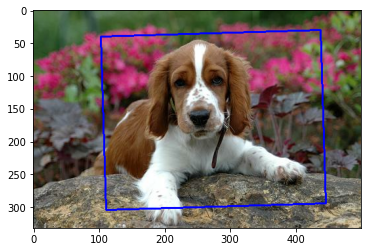

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

----

###IOU 결과 확인

In [ ]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09036144578313253, 0.206, 0.9156626506024096, 0.892]

In [ ]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7304934491327072

-----

##Grad CAM IOU 구하기

Grad CAM IOU도 한번 구해보겠습니다.

CAM IOU를 구하는 방식과 유사하며

함수를 generate_grad_cam으로만 바꾸어주면 됩니다.

67


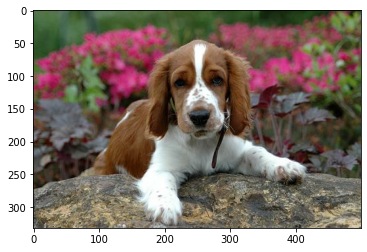

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

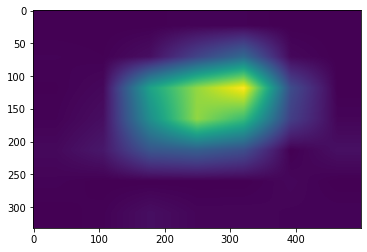

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [ ]:
get_bbox(grad_cam_image, score_thresh=0.05)

array([[ 83,  30],
       [448,  30],
       [448, 252],
       [ 83, 252]])

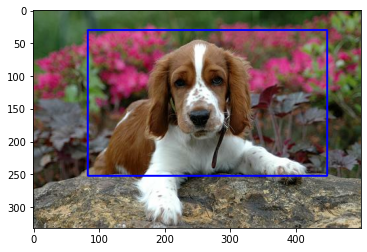

In [ ]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09036144578313253, 0.166, 0.7590361445783133, 0.896]

In [ ]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6270423823273996

---

##번외

**Grad CAM은 각 레이어의 CAM을 확인**할수가 있습니다.

그렇다면 각 레이어 IOU도 뽑을수 있을것입니다.

한번 **레이어별 IOU를 계산**해보겠습니다.

80


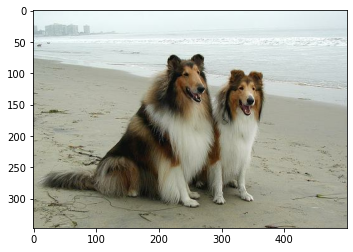

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

---

###레이어별 Grad CAM 출력

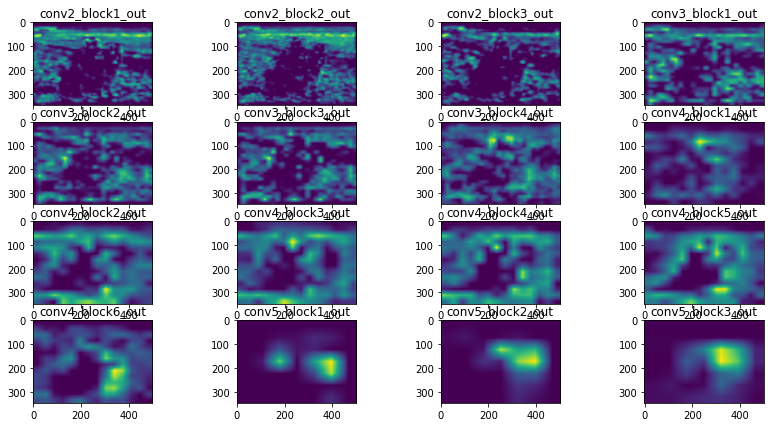

In [ ]:
import math

len_ = len(names)  # 16
cols = 4
rows = math.ceil(len_//cols)

plt.figure(figsize=(14,7))
j = 1

for i in range(len(names)):
    plt.subplot(rows,cols,j)
    plt.title(names[i])
    grad_cam_image = generate_grad_cam(cam_model, names[i], item)
    plt.imshow(grad_cam_image)
    j += 1

plt.show()

---

###레이어별 바운딩 박스 생성

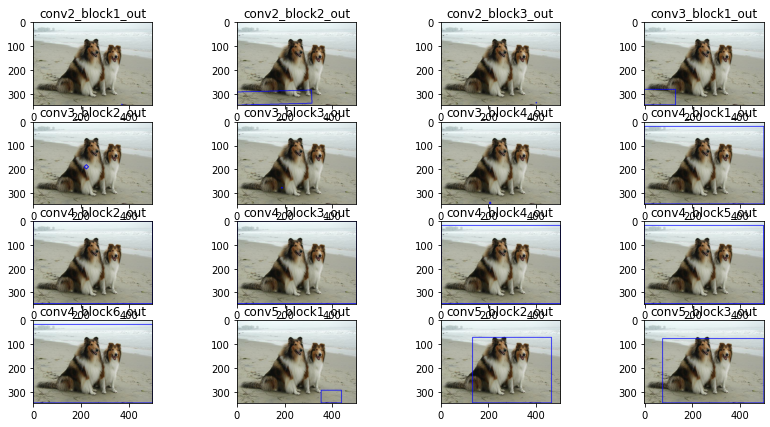

In [ ]:
import math

len_ = len(names)  # 16
cols = 4
rows = math.ceil(len_//cols)

plt.figure(figsize=(14,7))
j = 1

for i in range(len(names)):
    plt.subplot(rows,cols,j)
    plt.title(names[i])
    grad_cam_image = generate_grad_cam(cam_model, names[i], item)
    get_bbox(grad_cam_image, score_thresh=0.05)
    rect = get_bbox(grad_cam_image)
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)

    j += 1

plt.show()

---

###레이어별 IOU 계산

In [ ]:
for i in range(len(names)):
    grad_cam_image = generate_grad_cam(cam_model, names[i], item)
    get_bbox(grad_cam_image, score_thresh=0.05)
    rect = get_bbox(grad_cam_image)
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    rect_to_minmax(rect, image)
    pred_bbox = rect_to_minmax(rect, item['image'])
    def get_iou(boxA, boxB):
      y_min = max(boxA[0], boxB[0])
      x_min= max(boxA[1], boxB[1])
      y_max = min(boxA[2], boxB[2])
      x_max = min(boxA[3], boxB[3])
    
      interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
      boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
      boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
      iou = interArea / float(boxAArea + boxBArea - interArea)

      return iou
    print(i+1," 번째 : ",get_iou(pred_bbox, item['objects']['bbox'][0]))

1  번째 :  0.0
2  번째 :  0.10472971171748278
3  번째 :  0.0
4  번째 :  0.05458197807176068
5  번째 :  0.004720692178375751
6  번째 :  0.0001748404510509545
7  번째 :  0.0
8  번째 :  0.42451571513429753
9  번째 :  0.39947618159625564
10  번째 :  0.3986756281261229
11  번째 :  0.42146569617953583
12  번째 :  0.42146569617953583
13  번째 :  0.41933869421802555
14  번째 :  0.0
15  번째 :  0.3171953766000898
16  번째 :  0.38090183230497304


---

##마무리

어려웠던 점

- Grad CAM IOU값 구하기

- Grad CAM에 렐루(Relu)적용하기

- 여러 레이어 IOU값 뽑아내기

- IOU값으로 0이 나옴

###결론

lOU값

|CAM|Grad CAM|
|---|---|
|0.73|0.62|

프로젝트를 실제로 진행전 실습에서는 Grad CAM 성능이 더 좋을줄 알았습니다.

하지만 **프로젝트를 진행해보니 Grad CAM은 모델이 어떠한 방식으로 학습하는지 알기 위해서**

**만든 모델일뿐 딱히 성능 개선을 위해 만든 모델은 아니였습니다**.

그래서 **CAM IOU가 더 높다 Grad CAM IOU가 더 높다에 정답은 없는거 같습니다**.

또한 **Grad CAM에 Relu를 적용하면 더 좋아진다고 논문에 나와있었지만**

**막상 적용시켜보니 그저그런거 같습니다**.

**물론 학습을 더 많이 시키거나 백본 네트워크로 다른걸 쓰게 된다면 결과는 달라질 수 있다고 생각합니다**.
